# Detección de anomalías
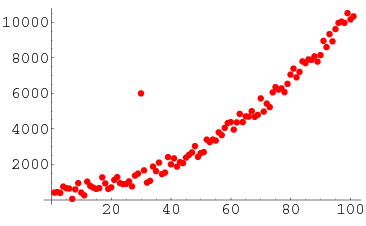

Una anomalía o *outlier* es una observación que no pertence a una cierta población. Es una muestra anormal que se aleja del resto de valores. 

Por ejemplo, si estamos midiendo la tempoeratura en Madrid y obtenemos `[20, 24, 22, 19, 29, 18, 4300, 30]`.

Es fácilmente identificable cuando las observaciones son pocas y tienen una única dimensión, pero cuando tenemos miles de observaciones multi-dimensionales, necesitamos otras formas de detectar estos valores.

**¿Por qué hay que preocuparse de los outliers?**  
Existen muchos problemas en los que es necesario encontrar valores atípicos, por ejemplo anomalías en el ritmo cardiaco para predecir enfermedades cardiovasculares; o anomalías en patrones de tráfico que permitan prevenir accidentes, entre otros.  
Otra razón por la cual necesitamos detectar anomalías es para preparar los datasets para modelos de machine learning. Es importante detectar todos los outliers, bien para deshacernos de ellos o analizarlos en profundidad.   

En este notebook veremos algunos métodos para tratar valores atípicos. Trabajaremos con este conjunto de datos

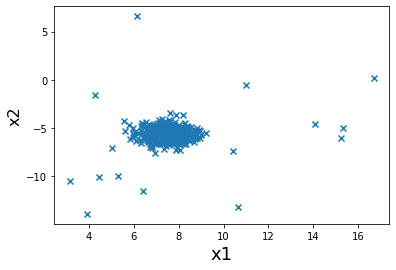

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=500, centers=1, cluster_std=0.60, random_state=5)
X_append, y_true_append = make_blobs(n_samples=20,centers=1, cluster_std=5,random_state=5)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] 
plt.scatter(X[:,0],X[:,1],marker="x");
plt.xlabel('x1', fontsize=18);
plt.ylabel('x2', fontsize=16);

In [2]:
import pandas as pd
import numpy as np

### 1. Desviación estándar

En estadística, si una distribución se puede aproximar a una normal, entonces el 99.7% de los valores se encuentran en el intervalo de ±3 desviaciones estándar. Por tanto, los puntos que estén más alejados de 3 veces la desviación estándar, son candidatos a ser valores atípicos

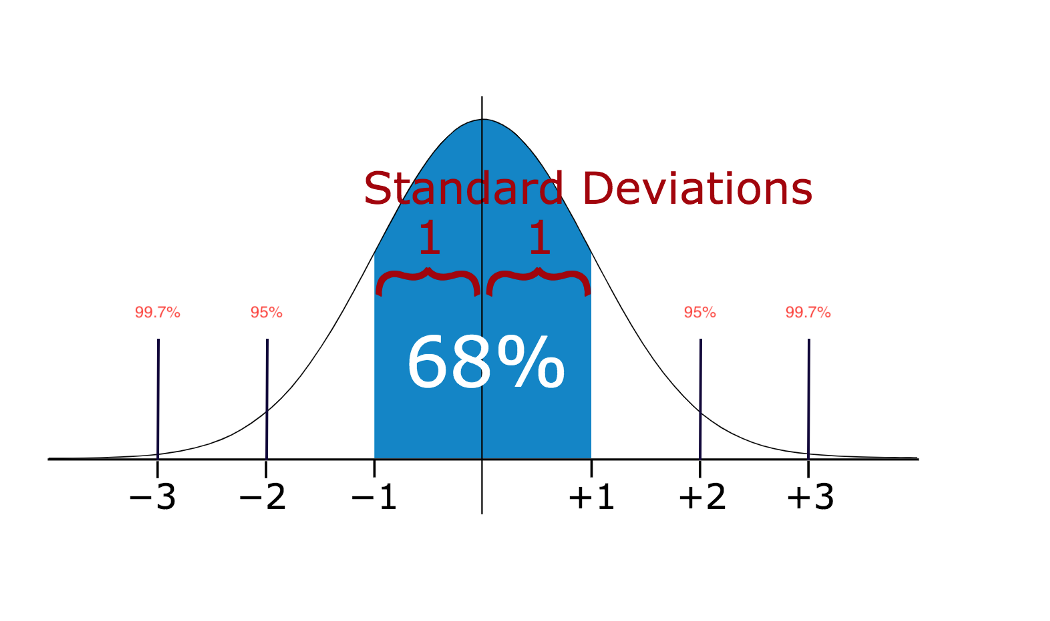



**Do it yourself**: Programa una función que reciba como entrada un array de valores y devuela los índices de los valores atípicos utilizando el método de la desviación estándar, en caso de existir. Busca los valores atípicos para las variables $x_1$ y $x_2$

In [5]:
import numpy as np
def find_anomalies(data):
    anomalies = []
    pos = []
    
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cutoff = data_std*3
    
    lower_limit = data_mean - anomaly_cutoff
    upper_limit = data_mean + anomaly_cutoff
    
    k = 0
    for point in data:
        if point > upper_limit or point < lower_limit:
            anomalies.append(point)
            pos.append(k)
        k+=1
    return anomalies,pos

In [9]:
anom1 = find_anomalies(X[:,0])
anom1

([4.25678797458645,
  15.327051708855343,
  3.1303803499670773,
  10.63888367801142,
  10.976752477930367,
  3.91375093509777,
  14.088888994755436,
  16.701301159704087,
  15.22230759079198],
 [500, 507, 508, 511, 514, 515, 516, 517, 519])

In [10]:
anom2 = find_anomalies(X[:,1])
anom2

([-1.594869980895361,
  -10.106298602486419,
  -11.52395964031424,
  -10.463176004298319,
  -9.919532494483477,
  -13.116034366647039,
  -0.5779374436384002,
  -13.884079225563681,
  0.1968184692306414,
  6.59371935683369],
 [500, 504, 505, 508, 510, 511, 514, 515, 517, 518])

In [12]:
p1 = X[anom1[1]]
p2 = X[anom2[1]]

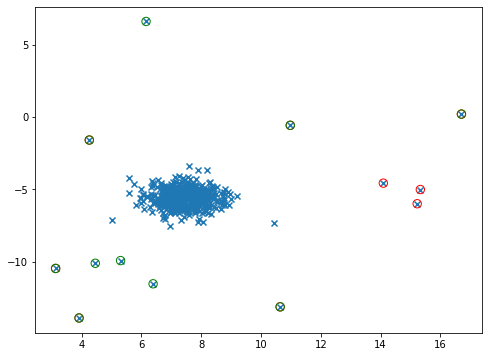

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], marker="x")
plt.scatter(p1[:,0],p1[:,1],marker="o",facecolor="none",edgecolor="r",s=70)
plt.scatter(p2[:,0],p2[:,1],marker="o",facecolor="none",edgecolor="g",s=70)

### 2. Rango intercuartílico 

Las variables no siempre siguen una distribución normal. Un buen estadístico para describir datos no gaussianos es el rango intercuartílico (IQR). Se calcula como la diferencia entre el percentil 25 y 75 de los datos, y define la caja en un gráfico de cajas.

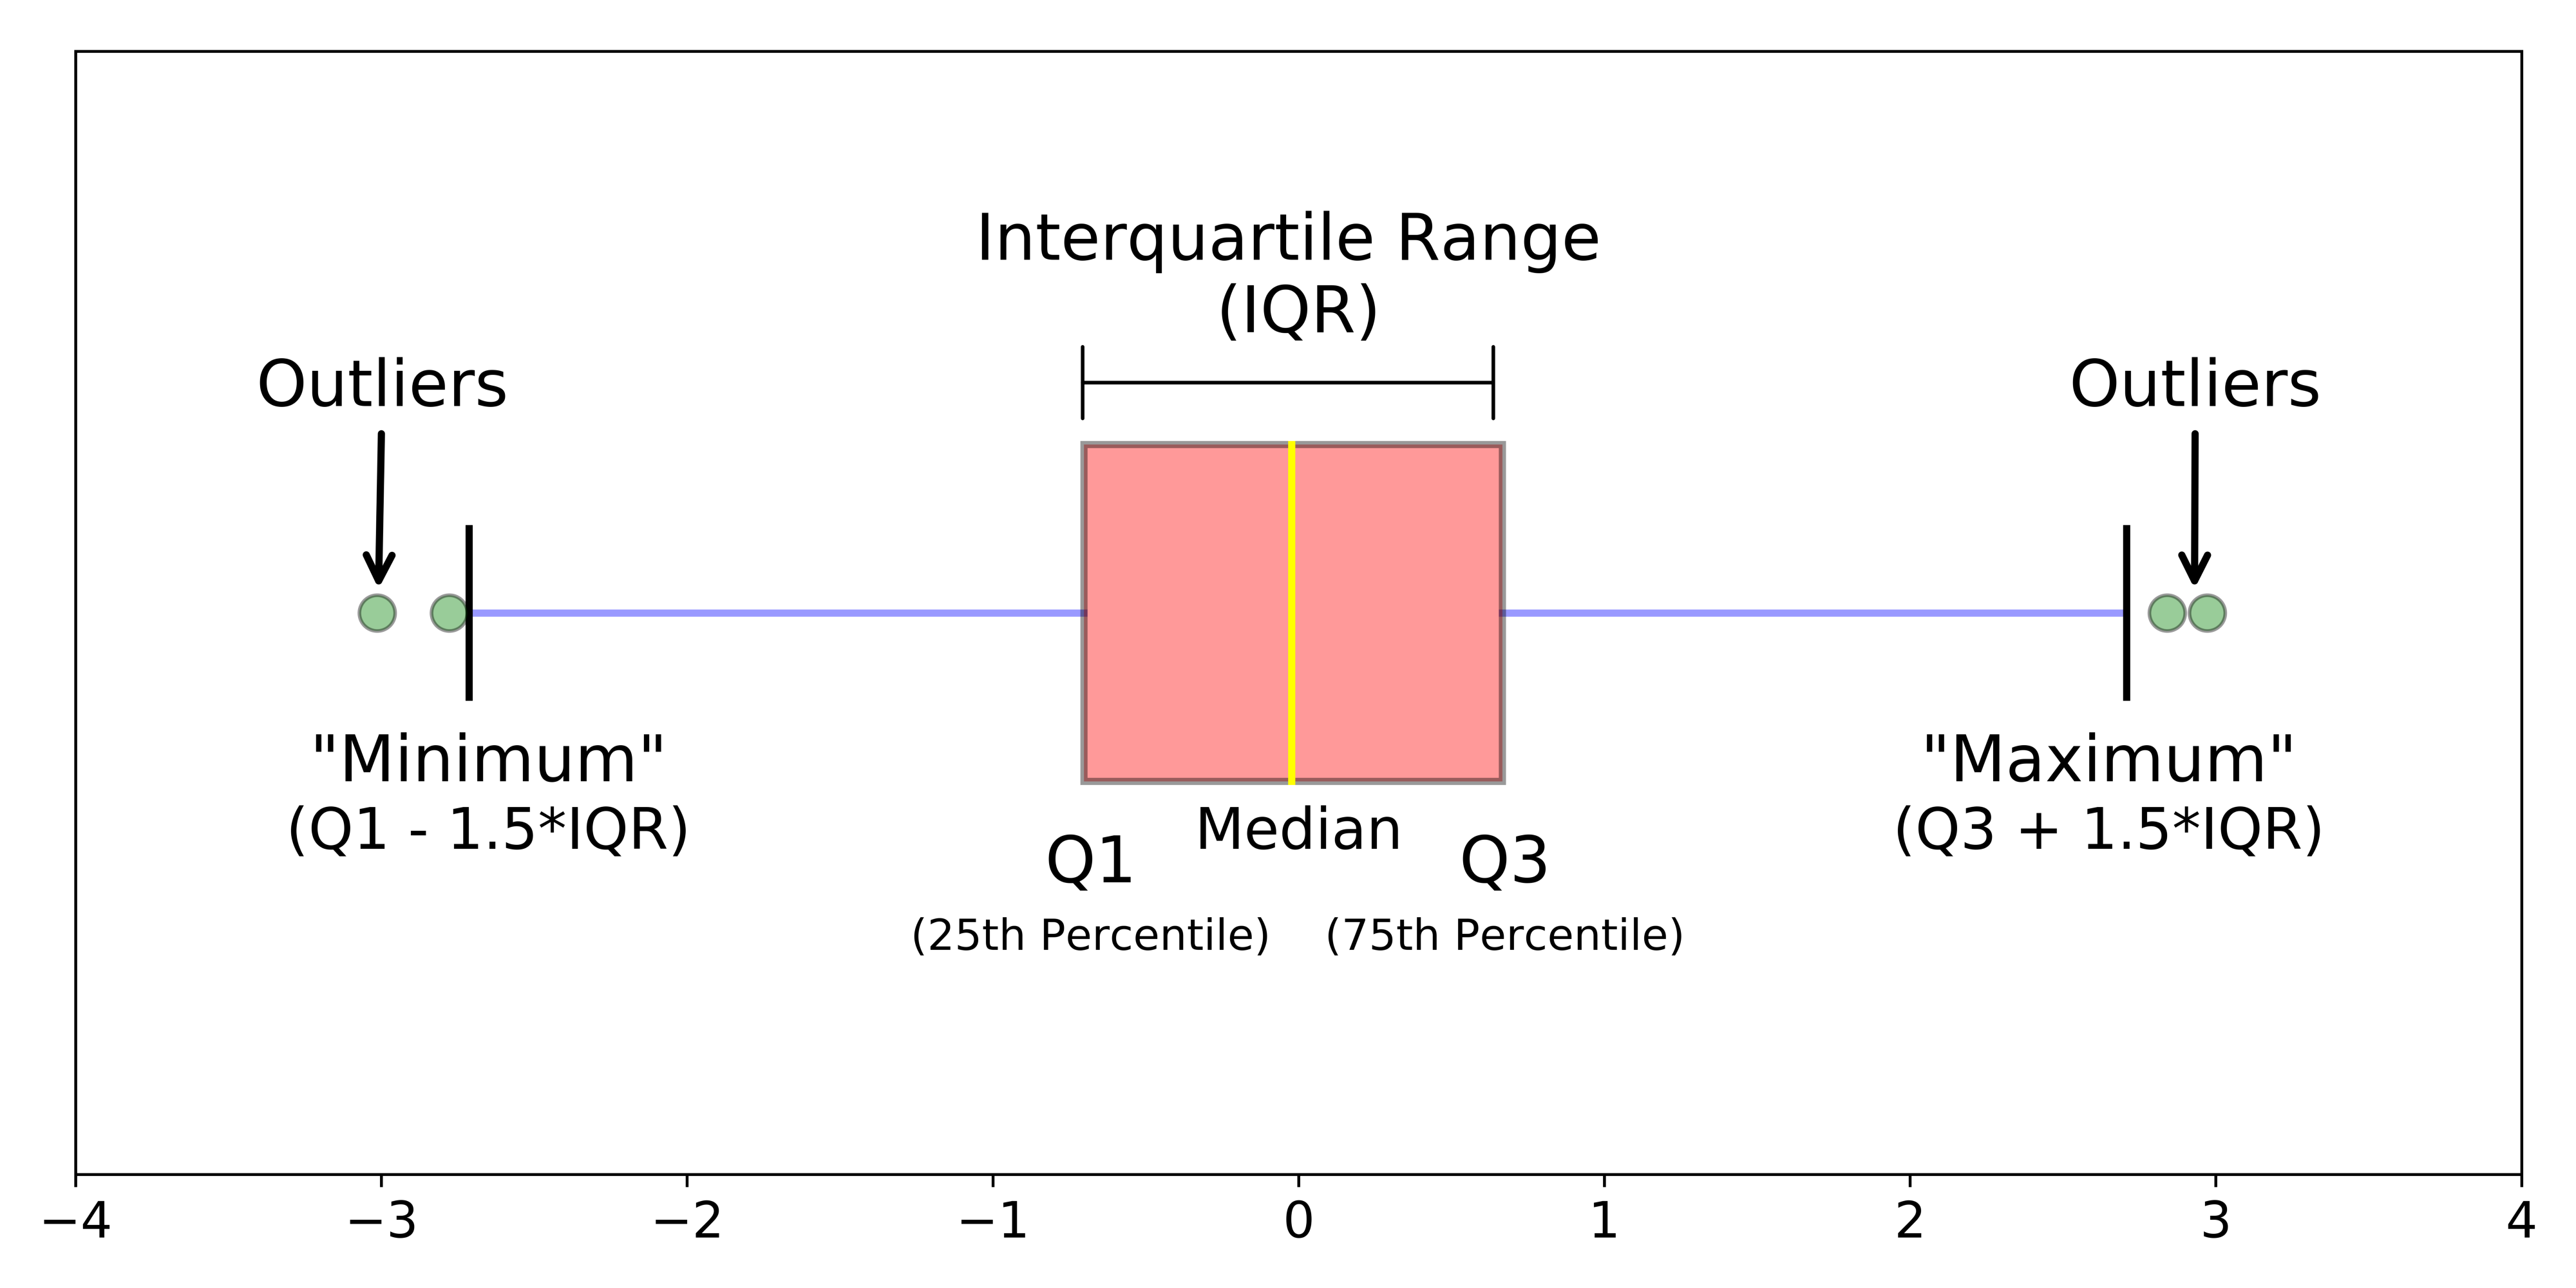

Recuerda que los percentiles se calculan ordenando las observaciones y seleccionando los valores en índices específicos. Por ejemplo, el percentil 50 (mediana) es el valor en el medio

El IQR se puede utilizar para identificar valores atípicos definiendo límites en los valores de la muestra que son un factor k del IQR por debajo del percentil 25 o por encima del percentil 75. El valor común del factor k es 1.5. Se puede usar un factor k de 3 o más para identificar valores que son valores atípicos extremos o "muy alejados" 

**Do it yourself**: Programa una función que reciba como entrada un array de valores y devuelva los índices de los valores atípicos utilizando el método del rango intercuartílico. Busca los valores atípicos para las variables $x_1$ y $x_2$  
NOTA: Para calcular percentiles, utiliza `numpy.percentile`

In [34]:
def outliers_IQR(data,factor=1.5):
    q25 = np.percentile(data,25)
    q75 = np.percentile(data,75)
    iqr = q75-q25
    
    cutoff = iqr * factor
    lower = q25-cutoff
    upper = q75+cutoff
    
    anomalies = []
    pos = []
    
    k = 0
    for x in data:
        if x<lower or x>upper:
            anomalies.append(x)
            pos.append(k)
        k += 1
        
    return anomalies,pos

In [35]:
anom1 = outliers_IQR(X[:,0])
anom2 = outliers_IQR(X[:,1])

In [36]:
p1 = X[anom1[1]]
p2 = X[anom2[1]]

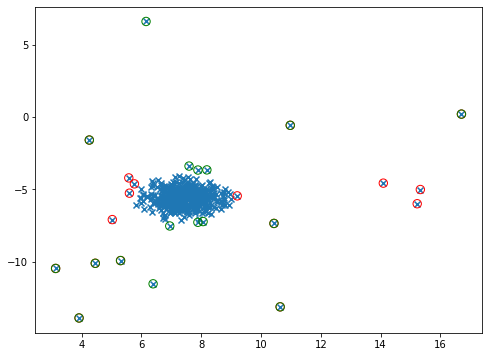

In [37]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x");
# Circling of anomalies
outliers = p1
plt.scatter(p1[:,0],p1[:,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.scatter(p2[:,0],p2[:,1],marker="o",facecolor="none",edgecolor="g",s=70);

### 3. DBSCAN

Tal y como vimos en los algoritmos de clustering, DBSCAN etiqueta con -1 a los puntos "ruidosos" o anómalos  
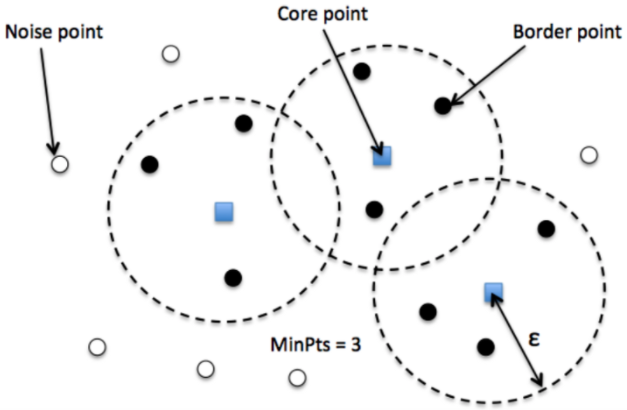

**Do it yourself**: Aplica DBSCAN a nuestro conjunto de datos y muestra los puntos anómalos

In [47]:
from sklearn.cluster import DBSCAN

outlier_detection = DBSCAN(min_samples =4, eps =1)
clusters = outlier_detection.fit_predict(X)
outliers = X[clusters==-1]

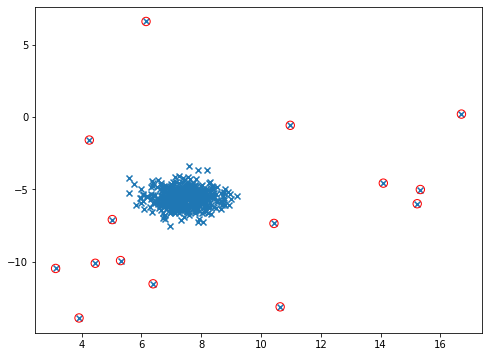

In [48]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x");
# Circling of anomalies

plt.scatter(outliers[:,0],outliers[:,1],marker="o",facecolor="none",edgecolor="r",s=70);


### 4. Isolation Forest

In [70]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.01)
preds = clf.fit_predict(X)
preds

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [67]:
clf.score_samples(X)

array([-0.36252249, -0.39652793, -0.35866246, -0.36339511, -0.38379509,
       -0.36463647, -0.38494211, -0.40473034, -0.37929625, -0.37276043,
       -0.3698993 , -0.35997998, -0.36025631, -0.4473022 , -0.4534584 ,
       -0.37373025, -0.38673711, -0.39104862, -0.38143225, -0.36489363,
       -0.4403045 , -0.36485295, -0.37869276, -0.39940377, -0.417422  ,
       -0.36807078, -0.36231581, -0.38658765, -0.36551654, -0.35644255,
       -0.433163  , -0.44262364, -0.39882307, -0.3685157 , -0.47245811,
       -0.45762234, -0.35523685, -0.35672292, -0.37797322, -0.39095421,
       -0.37386988, -0.37143309, -0.37369728, -0.36706953, -0.40987188,
       -0.46560912, -0.36690289, -0.36192763, -0.44634501, -0.36176992,
       -0.45630517, -0.4022069 , -0.36359198, -0.36179125, -0.36951767,
       -0.40270471, -0.35781125, -0.37486983, -0.36629577, -0.36161194,
       -0.44877023, -0.35009949, -0.38291266, -0.37956945, -0.35636514,
       -0.37844091, -0.36675209, -0.35596389, -0.45191541, -0.36

In [71]:
outliers = X[preds==-1]

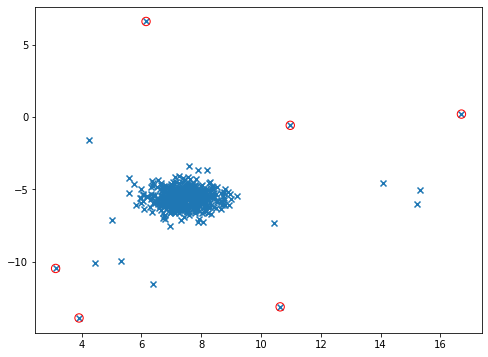

In [72]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x");
# Circling of anomalies
plt.scatter(outliers[:,0],outliers[:,1],marker="o",facecolor="none",edgecolor="r",s=70);
